Import all the needed libraries

In [ ]:
from sklearn import datasets
from keras.datasets import mnist
from matplotlib import pyplot as plt
from collections import Counter
from math import sqrt
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (accuracy_score, silhouette_score, 
                             homogeneity_score, completeness_score, 
                             v_measure_score, adjusted_rand_score)

---

# Get and Know the Data
Get data (digits) from sklearn or MNSIT.

Create a object for each different data sets, sothe information can be store equally no matter the data set.

In [ ]:
class Digits():
    def __init__(self, data_set):
        self.data_set = data_set
        self.target = None
        self.data = None
        self.dimension = 0
        self.get_data()

    def get_data(self):
        if self.data_set == "MNIST":
            (x_train, y_train), (x_test, y_test) = mnist.load_data()
            # Convert each image to a 1D array
            self.data = x_train.reshape(x_train.shape[0], -1)
            self.target = y_train

        elif self.data_set == "sklearn":
            info = datasets.load_digits()
            self.data = info.data
            self.target = info.target

        self.dimension = int(sqrt(self.data.shape[1]))

In [ ]:
digits = Digits("sklearn")

Know the given data

In [ ]:
n_samples = digits.data.shape[0]
n_dimensions = digits.dimension ** 2
print(f"Samples: {n_samples} \nDimensions: {n_dimensions}")
print(f"It's a {int(sqrt(n_dimensions))}x{int(sqrt(n_dimensions))} image")

Samples: 1797 
Dimensions: 64
It's a 8x8 image


Its distribution:

Text(0, 0.5, 'Number of pictures')

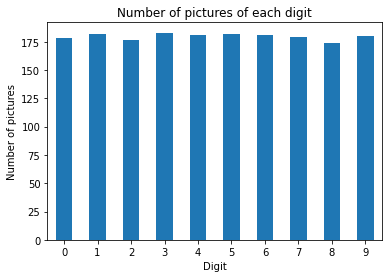

In [ ]:
target = pd.arrays.PandasArray(digits.target)

target.value_counts().sort_index().plot.bar()
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Number of pictures of each digit")
plt.xlabel("Digit")
plt.ylabel("Number of pictures")

---
# Compute the K-*Means*

Get the 10 clusters

In [ ]:
# Data to use
data = digits.data

# Fit K-means with Scikit
n = len(np.unique(target))
model = KMeans(n_clusters=n, random_state=0)
model.fit(data)

# Indexes of the cluster each sample belongs to
clusters = model.predict(data)

Label each cluster with their true labels. <br>
This happens because k-means know nothing aboth the identity of each cluster, so the digits that appears more in each cluster is their label.

<table>
  <tr>
    <th>Variable</th> <th>Values</th>
  </tr>
  <tr>
    <td>cluster</td> <td>[1,2,3,4,5,5,0,...</td>
  </tr>
  <tr>
    <td>i</td> <td>5</td>
  </tr>
  <tr>
    <td>mask</td> <td>[F,F,F,F,T,T,F,...</td>
  </tr>
  <tr>
    <td>target</td> <td>(0,0), (1,1), (2,2),...</td>
  </tr>
  <tr>
    <td>target[mask]</td> <td>(4,4), (15,4), (16,4),...</td>
  </tr>
  <tr>
    <td>labels[mask]</td> <td>[0,0,0,0,5,5,0,...</td>
  </tr>
</table>

In [ ]:
# Save the label of each cluster
labels = np.zeros_like(clusters)

# Check the most repeated digit in each cluster and it will be the label
# for that cluster
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(target[mask])[0]

Cluster Digit
0       [4]
1       [3]
2       [5]
3       [9]
4       [7]
5       [0]
6       [1]
7       [8]
8       [2]
9       [6]


Visualize the cluster's center of each cluster

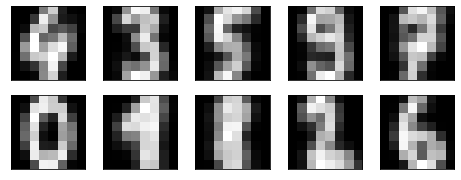

In [ ]:
# Get centers
dim = digits.dimension
centers = model.cluster_centers_.reshape(n, dim, dim)

# Draw each center
fig, ax = plt.subplots(2, n//2, figsize=(8, 3))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, cmap="gray")

Check the number of digits gotten in each cluster

Text(0, 0.5, 'Number of pictures')

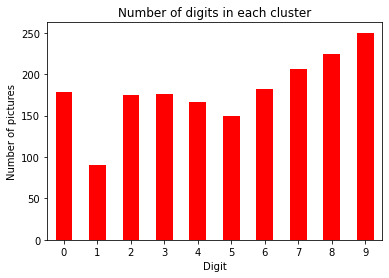

In [ ]:
# Convert the output to Pandas array and get the number of data points in each cluster
prediction = pd.arrays.PandasArray(labels)
prediction.value_counts().sort_index().plot.bar(color="red")

# Show the bat plot
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Number of digits in each cluster")
plt.xlabel("Digit")
plt.ylabel("Number of pictures")

---
# Analize the data

Get how many digits are in each cluster, vs the real amount

Text(0, 0.5, 'Number of data points')

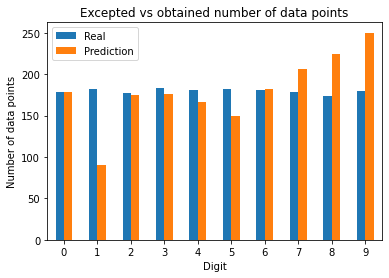

In [ ]:
# Get the number of pictures in for each number and convert it to numpy
target_counts = target.value_counts().sort_index().to_numpy()
prediction_counts = prediction.value_counts()

# If a there is a digit with 0 items, add it with a total number of 0
n_digits = 10
for d in range(10):
    if d not in prediction_counts.index:
        prediction_counts.loc[d] = 0

# DF with target and predictions for each number
df = pd.DataFrame({'Real': target_counts,
                   'Prediction': prediction_counts}, 
                  index = [i for i in range(10)])

# Draw the plot
df.plot.bar(rot=0)
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Excepted vs obtained number of data points")
plt.xlabel("Digit")
plt.ylabel("Number of data points")

Check an estimation of how many digits were correctly predicted

In [ ]:
# Get how accurate the prediction was
accuracy = accuracy_score(target, prediction)
print(f"Accuracy: {accuracy * 100 :.1f}%")

Accuracy: 79.4%


Check in which digits the error was more frecuent

Text(0.5, 0.98, 'Data points predicted vs their true label')

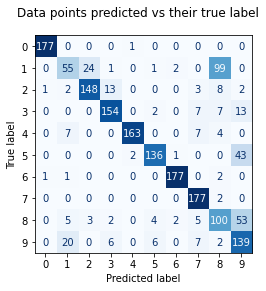

In [ ]:
# With a confusion matrix check the true label vs the predicted label
disp = ConfusionMatrixDisplay.from_predictions(target, prediction, 
                                               cmap=plt.cm.Blues, 
                                               colorbar=False)

# Draw the plot
fig = disp.ax_.get_figure()
fig.suptitle("Data points predicted vs their true label")

See how well the model performed

> **Homogeneity:** each cluster contains only members of a single class.

> **Completeness:** all members of a given class are assigned to the same cluster.

> **V-measure:** the harmonic mean between homogeneity and completeness

> **Rand index:** proportional to the number of sample pairs whose labels are the same in both labels_pred and labels_true or are different in both.

In [ ]:
def bench_k_means(kmeans, targets, labels):
    results = []
    clustering_metrics = [homogeneity_score, completeness_score, 
                          v_measure_score, adjusted_rand_score]
    # Compute each test
    results += [test(targets, labels) for test in clustering_metrics]

    return results


results = bench_k_means(model, target, labels)
tests = ["Homogeneity", "Completeness", "V-measure", "Rand Index"]

for test, result in zip(tests, results):
    print(f"{test}: {result:.2f}%")

Homogeneity: 0.74%
Completeness: 0.75%
V-measure: 0.75%
Rand Index: 0.67%


**Inertia**: intra-cluter distance. Is the cluster compact or not. The less the better.

**Silhouette Coefficient:** mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. Best value is 1, worst is -1

In [ ]:
sum_of_squared_distances = []
silhouette_scores = []
for k in range(2, 15):
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    y = km.predict(data)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(data, y))

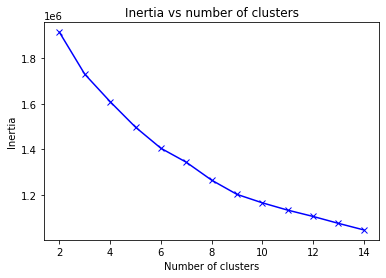

In [ ]:
plt.plot(range(2, 15), sum_of_squared_distances, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Inertia vs number of clusters")
plt.show()

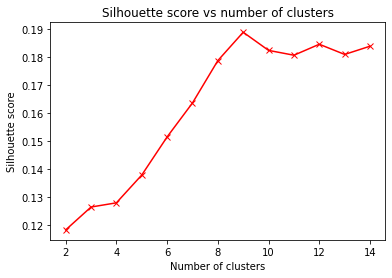

In [ ]:
plt.plot(range(2, 15), silhouette_scores, "rx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs number of clusters")
plt.show()